# CLIP-DINOiser visualization demo 🖼️

In [ ]:
from hydra.core.global_hydra import GlobalHydra
import os
from models.builder import build_model
from helpers.visualization import mask2rgb
from segmentation.datasets import PascalVOCDataset
from hydra import compose, initialize
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T
import torch
import warnings
warnings.filterwarnings('ignore')
GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)

def visualize_per_image(file_path, support_files, palette, model, class_names):
    # Assert that the main image exists
    assert os.path.isfile(file_path), f"No such file: {file_path}"
    
    # print(f"Dataset classes: {dataset_classes}")

    # Open and preprocess the main image
    img = Image.open(file_path).convert('RGB')
    img_tens = T.PILToTensor()(img).unsqueeze(0).to(device) / 255.

    # Load and preprocess support images
    support_images = []
    for support_file in support_files:
        assert os.path.isfile(support_file), f"No such file: {support_file}"
        support_img = Image.open(support_file).convert('RGB')

        # Resize the support images to match the size of the main image
        support_img_resized = support_img.resize(img.size, Image.BILINEAR)

        # Convert to tensor and normalize
        support_img_tens = T.PILToTensor()(support_img_resized).unsqueeze(0).to(device) / 255.
        support_images.append(support_img_tens)
    
    # Stack the support images into a batch
    support_images = torch.cat(support_images, dim=0).to(device)  
    # for spt in support_images:
    #     print(spt.shape)
    
    # Get the original height and width of the image
    h, w = img_tens.shape[-2:]
    merged = torch.cat((img_tens, support_images), dim=0)
    # print(f'merged: {merged.shape}')
    
    # Run the model for segmentation using both the main image and the support images
    output = model(merged).cpu()  # Ensure your model can accept both inputs
    output = F.interpolate(output, scale_factor=model.vit_patch_size, mode="bilinear", align_corners=False)[..., :h, :w]
    
    # Visualizza le probabilità per ogni classe
    # output[0] contiene le probabilità per ciascun pixel e ciascuna classe
    # output[0].shape sarà [C, H, W], dove C è il numero di classi
    
    # Itera su tutte le classi per stampare le probabilità
    # C, H, W = output[0].shape
    # for class_idx in range(C):
    #     class_probs = output[0][class_idx]
    #     print(f"Classe {class_idx}:")
    #     print(f"Probabilità media per classe {class_idx}: {class_probs.mean().item()}")
    #     print("-" * 50)
    
    output = output[0].argmax(dim=0)  # Get the most likely class for each pixel
    
    # Convert the output to an RGB mask using the provided palette
    mask = mask2rgb(output, palette)

    # Extract unique class indices from the output mask and map to the palette
    detected_classes = np.unique(output).tolist()
    # print(f"Detected classes (indices): {detected_classes}")

    # Filter out the classes that were not detected and print their names
    detected_class_names = [class_names[idx] for idx in detected_classes if idx < len(class_names)]
    # print(f"Detected class names: {detected_class_names}")

    # Create the visualization: segmented mask and original image
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    # Blending the original image with the mask for visualization
    alpha = 0.5
    blend = (alpha) * np.array(img) / 255. + (1 - alpha) * mask / 255.
    ax[0].imshow(blend)
    ax[0].axis('off')
    
    ax[1].imshow(mask)
    ax[1].axis('off')
    
    # Visualization of class colors along with support image file names as labels
    class_colors = np.array([palette[class_idx] for class_idx in detected_classes if class_idx < len(palette)])
    plt.figure(figsize=(6, 1))
    plt.imshow(class_colors.reshape(1, -1, 3))
    plt.xticks(np.arange(len(detected_class_names)), detected_class_names, rotation=45)
    plt.yticks([])

    return mask, fig, img

check_path = './checkpoints/last.pt'
check = torch.load(check_path, map_location='cpu')
dinoclip_cfg = "clip_dinoiser.yaml"
cfg = compose(config_name=dinoclip_cfg)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model(cfg.model, class_names=PascalVOCDataset.CLASSES).to(device)
model.clip_backbone.decode_head.use_templates = False  # switching off the imagenet templates for fast inference
model.load_state_dict(check['model_state_dict'], strict=False)
model = model.eval()
# TEST WITH TWO SUPPORT IMAGES
file = 'assets/airplane.jpg'
support_files = ['assets/air2.jpg']  # Two support images

PALETTE = [(0, 0, 0), (156, 143, 189), (79, 158, 101)]

# Run segmentation with two support images, no text prompts required
model.apply_found = True  # assuming this flag is still relevant for your setup

# Lista dei nomi delle classi (questo esempio è per 3 classi)
class_names = ['background', 'aeroplane', 'bicycle']
# Run segmentation
mask, ticks, img = visualize_per_image(file, support_files, PALETTE, model, class_names)

# Evaluation

Evaluating 1-way 1-shot...
Starting evaluation...
Images per class collected.
Selected 1 classes and 1 images per class for support set.
Query image selected.


Processing class dog with merged images.


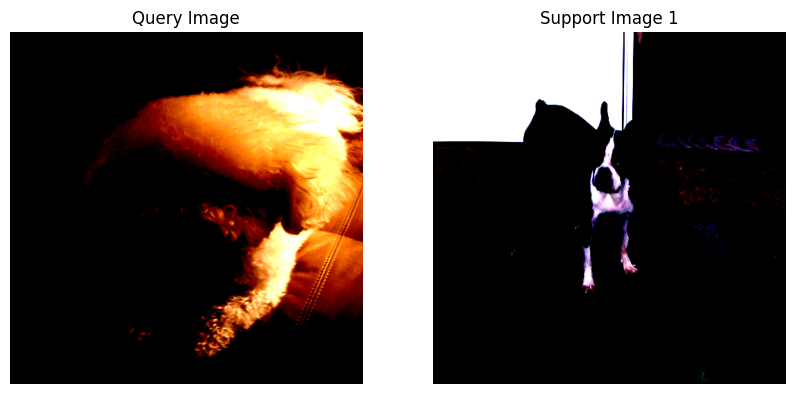

Calculating confusion matrix...
Tested on class dog
Evaluation completed.
1-way 1-shot mIoU: 0.04833084227391297
Evaluating 2-way 1-shot...
Starting evaluation...
Images per class collected.
Selected 2 classes and 1 images per class for support set.
Query image selected.


Processing class boat with merged images.


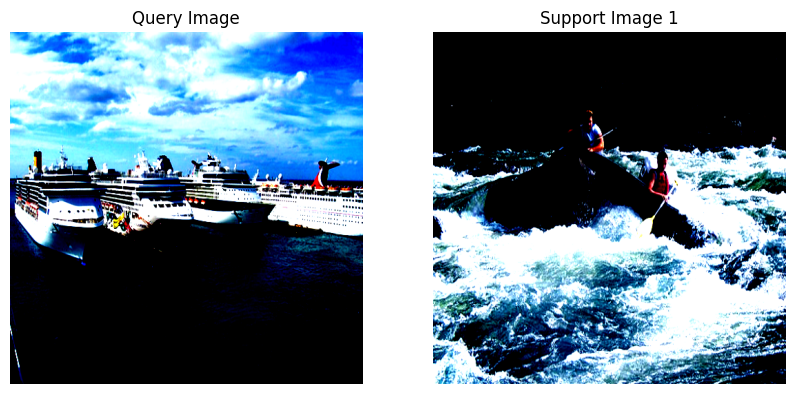

Calculating confusion matrix...
Tested on class boat
Processing class motorbike with merged images.


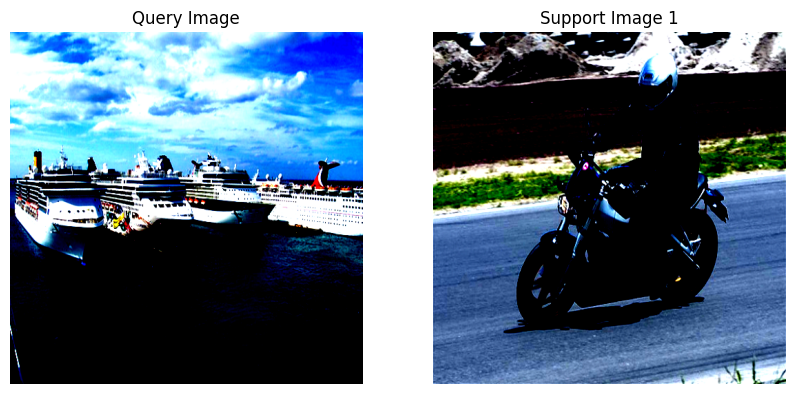

Calculating confusion matrix...
Tested on class motorbike
Evaluation completed.
2-way 1-shot mIoU: 0.04047390950283685


In [32]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from datasets_custom import PascalVOCDataset
import random
import matplotlib.pyplot as plt

dinoclip_cfg = "clip_dinoiser.yaml"
cfg = compose(config_name=dinoclip_cfg)

def visualize_selected_images(query_image, support_images):
    """
    Visualize the selected query image and support images.

    Args:
        query_image (Tensor): The query image tensor.
        support_images (list of Tensors): List of support image tensors.
    """
    # Convert tensors to numpy arrays for visualization
    query_image_np = query_image.squeeze().cpu().numpy().transpose(1, 2, 0)
    support_images_np = [img.squeeze().cpu().numpy().transpose(1, 2, 0) for img in support_images]

    # Plot the query image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, len(support_images) + 1, 1)
    plt.imshow(query_image_np)
    plt.title("Query Image")
    plt.axis('off')

    # Plot the support images
    for i, support_image_np in enumerate(support_images_np):
        plt.subplot(1, len(support_images) + 1, i + 2)
        plt.imshow(support_image_np)
        plt.title(f"Support Image {i + 1}")
        plt.axis('off')

    plt.show()

def get_images_per_class(dataset):
    """
    Get images for each class from the dataset.

    Args:
        dataset (PascalVOCDataset): The dataset to search.

    Returns:
        dict: Dictionary of images for each class.
    """
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)
    classes = PascalVOCDataset.CLASSES
    images_per_class = {class_name: [] for class_name in classes}

    for idx, data in enumerate(dataloader):
        images, targets = data
        for class_idx in targets.unique().tolist():
            if class_idx < len(classes):  # Ensure class_idx is within valid range
                class_name = classes[class_idx]
                images_per_class[class_name].append(images)
    print("Images per class collected.")
    return images_per_class

def select_n_way_k_shot(images_per_class, N, K):
    """
    Select N classes and K images for each class.

    Args:
        images_per_class (dict): Dictionary of images for each class.
        N (int): Number of classes.
        K (int): Number of images per class.

    Returns:
        dict: Dictionary of selected images for each class.
    """
    selected_classes = random.sample(list(images_per_class.keys()), N)
    support_set = {class_name: random.sample(images_per_class[class_name], K) for class_name in selected_classes}
    print(f"Selected {N} classes and {K} images per class for support set.")
    return support_set

def select_query_image(dataset, selected_classes):
    """
    Select a query image that contains at least one of the selected classes.

    Args:
        dataset (PascalVOCDataset): The dataset to search.
        selected_classes (list): List of selected class names.

    Returns:
        Tensor: Query image.
    """
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)
    classes = PascalVOCDataset.CLASSES
    selected_class_indices = [classes.index(class_name) for class_name in selected_classes]

    for idx, data in enumerate(dataloader):
        images, targets = data
        if any(class_idx in targets.unique().tolist() for class_idx in selected_class_indices):
            print("Query image selected.")
            return images

    raise ValueError("No query image found containing the selected classes.")

def evaluate_n_way_k_shot(model, dataset, N, K, num_classes):
    """
    Evaluate the model using N-way K-shot setting.

    Args:
        model (torch.nn.Module): The model to evaluate.
        dataset (PascalVOCDataset): The dataset to search.
        N (int): Number of classes.
        K (int): Number of images per class.
        num_classes (int): Number of classes.

    Returns:
        float: Mean IoU across all images.
    """
    print("Starting evaluation...")
    images_per_class = get_images_per_class(dataset)
    support_set = select_n_way_k_shot(images_per_class, N, K)
    query_image = select_query_image(dataset, list(support_set.keys()))

    model.eval()
    confusion_matrix = np.zeros((num_classes, num_classes))
    with torch.no_grad():
        for class_name, support_images in support_set.items():
            support_images = torch.cat(support_images, dim=0).to(device)
            query_image = query_image.to(device)

            # Resize images to the same size
            query_image = F.interpolate(query_image, size=(512, 512), mode='bilinear', align_corners=False)
            support_images = F.interpolate(support_images, size=(512, 512), mode='bilinear', align_corners=False)

            # Concatenate query image and support images
            merged = torch.cat((query_image, support_images), dim=0)
            print(f"Processing class {class_name} with merged images.")

            # Visualize the selected images
            visualize_selected_images(query_image, support_images)

            # Forward pass through the model
            outputs = model(merged)
            outputs = F.interpolate(outputs, size=query_image.shape[-2:], mode='bilinear', align_corners=False)
            preds = outputs.argmax(dim=1)
            confusion_matrix += calculate_confusion_matrix(preds, query_image, num_classes)
            print(f"Tested on class {class_name}")

    # Calculate mIoU from the confusion matrix
    intersection = np.diag(confusion_matrix)
    union = np.sum(confusion_matrix, axis=0) + np.sum(confusion_matrix, axis=1) - intersection
    iou = intersection / np.maximum(union, 1)
    miou = np.nanmean(iou)
    print("Evaluation completed.")
    return miou

import torch.nn.functional as F

def calculate_confusion_matrix(pred, target, num_classes):
    """
    Calculate the confusion matrix for a single batch.

    Args:
        pred (Tensor): Predicted segmentation map.
        target (Tensor): Ground truth segmentation map.
        num_classes (int): Number of classes.

    Returns:
        np.array: Confusion matrix for the batch.
    """
    
    print("Calculating confusion matrix...")
    # Ensure both tensors have the same number of dimensions
    if pred.dim() == 3:
        pred = pred.unsqueeze(0)
    if target.dim() == 3:
        target = target.unsqueeze(0)

    # Resize the larger tensor to match the smaller tensor's shape
    if pred.shape[-2:] != target.shape[-2:]:
        if pred.numel() > target.numel():
            pred = F.interpolate(pred.float(), size=target.shape[-2:], mode='nearest').long()
        else:
            target = F.interpolate(target.float(), size=pred.shape[-2:], mode='nearest').long()

    pred = pred.view(-1)
    target = target.view(-1).long()  # Convert target to integers

    # Ensure the mask and tensors are the same size
    if pred.shape != target.shape:
        min_size = min(pred.shape[0], target.shape[0])
        pred = pred[:min_size]
        target = target[:min_size]

    mask = (target >= 0) & (target < num_classes)
    hist = np.bincount(
        num_classes * target[mask].cpu().numpy() + pred[mask].cpu().numpy(),
        minlength=num_classes ** 2
    ).reshape(num_classes, num_classes)
    return hist
# Define the pipeline
pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(512, 512), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]

# Path to the Pascal VOC dataset
img_dir = '/Users/micheleverriello/LabelAnything/data/pascal/JPEGImages'
ann_dir = '/Users/micheleverriello/LabelAnything/data/pascal/SegmentationClass'
split_file = '/Users/micheleverriello/LabelAnything/data/pascal/ImageSets/Segmentation/val.txt'

# Load the Pascal VOC dataset with a limit of 2000 images
dataset = PascalVOCDataset(split=split_file, img_dir=img_dir, ann_dir=ann_dir, pipeline=pipeline, limit=2000)
num_classes = len(PascalVOCDataset.CLASSES)

# Evaluate 1-way 1-shot
print("Evaluating 1-way 1-shot...")
miou_1_way_1_shot = evaluate_n_way_k_shot(model, dataset, N=1, K=1, num_classes=num_classes)
print(f'1-way 1-shot mIoU: {miou_1_way_1_shot}')

# Evaluate 2-way 1-shot
print("Evaluating 2-way 1-shot...")
miou_2_way_1_shot = evaluate_n_way_k_shot(model, dataset, N=2, K=1, num_classes=num_classes)
print(f'2-way 1-shot mIoU: {miou_2_way_1_shot}')